#  DCGAN Keras Implementation
* Author: Johannes Maucher
* Last Update: 04.11.2021

In this notebook a GAN is designed, which learns to generate handwritten numbers between 0 and 9, like the ones, given in the MNIST dataset. In this case the real data is the MNIST dataset, which contains 70000 greyscale images of size 28x28, 7000 images for each of the 10 digits.

The Discriminator model is just a binary classifier, whose task is to distinguish fake, from real images. The fake images are produced by the Generator model. At it's input the Generator model receives 1-dimensional vectors of length 100, whose components are uniformly distributed random float-values between -1 and 1. The discriminator model is learned such that the *cross-entropy-loss* for discrimating real from fake images is minimized by Stochastic Gradient Descent (SGD). The Generator model is learned such that the generated fake data is classified as real-data by the discriminator.

Below a Deep Convolutional GAN (DCGAN) as introduced in [A. Radford and L. Metz: Unsupervised Representation Learning with Deep Convolutional GANs](https://arxiv.org/pdf/1511.06434.pdf) is implemented. This type of GAN applies a Convolutional Neural Net (CNN) for the Generator- and the Discriminator model.

In [1]:
#!pip install tqdm

In [2]:
import tensorflow.compat.v1.keras.backend as K # see https://stackoverflow.com/questions/61056781/typeerror-tensor-is-unhashable-instead-use-tensor-ref-as-the-key-in-keras
import tensorflow as tf
tf.compat.v1.disable_eager_execution()

ImportError: dlopen(/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/_pywrap_tfe.so, 0x0002): Library not loaded: @rpath/_pywrap_tensorflow_internal.so
  Referenced from: /Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/_pywrap_tfe.so
  Reason: tried: '/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/../../_solib_darwin_x86_64/_U_S_Stensorflow_Spython_C_Upywrap_Utfe.so___Utensorflow/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/../../_solib_darwin_x86_64/_U_S_Stensorflow_Spython_C_Upywrap_Utensorflow_Uinternal_Umacos___Utensorflow_Spython/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/../_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/../../_solib_darwin_x86_64/_U_S_Stensorflow_Spython_C_Upywrap_Utfe.so___Utensorflow/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/../../_solib_darwin_x86_64/_U_S_Stensorflow_Spython_C_Upywrap_Utensorflow_Uinternal_Umacos___Utensorflow_Spython/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/python3.8/site-packages/tensorflow/python/../_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/bin/../lib/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/lib/_pywrap_tensorflow_internal.so' (no such file), '/Users/johannes/opt/anaconda3/envs/books/bin/../lib/_pywrap_tensorflow_internal.so' (no such file), '/usr/local/lib/_pywrap_tensorflow_internal.so' (no such file), '/usr/lib/_pywrap_tensorflow_internal.so' (no such file)

In [10]:
from keras.datasets import mnist
from keras.models import Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tqdm import tqdm  #this package is used to show progress in training loops
from tensorflow.keras.layers import LeakyReLU
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

The MNIST-handwritten digits dataset is available in the Keras datasets module and can be accessed as follows:

In [11]:
(X_train, Y_train), (X_test, Y_test) = mnist.load_data()

In [12]:
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape

((60000, 28, 28), (60000,), (10000, 28, 28), (10000,))

In [13]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1)
X_test = X_test.reshape(X_test.shape[0], 28, 28, 1)
print(X_train.shape)
print(X_test.shape)

X_train = X_train.astype('float32')
print(X_train[0,:,:,0])

(60000, 28, 28, 1)
(10000, 28, 28, 1)
[[  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
    0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   3.  18.
   18.  18. 126. 136. 175.  26. 166. 255. 247. 127.   0.   0.   0.   0.]
 [  0.   0.   0.   0.   0.   0.   0.   0.  30.  36.  94. 154. 170. 253.
  253. 253. 253. 253

The values of all input-images range from 0 to 255. Next, a rescaling to the range $[-1,1]$ is performed. This is necesarry, because the output-layer of the Generator model applies a tanh-activation, which has a value rane of $[-1,1]$. 

In [14]:
X_train = (X_train - 127.5) / 127.5

print(X_train[0,:,:,0])

[[-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.         -1.         -1.
  -1.         -1.         -1.         -1.        ]
 [-1.         -1.         -1.         -1.         -1.  

The first 9 real images in the training dataset are plotted below: 

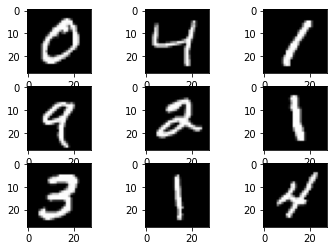

In [15]:
#plt.subplot(3,3,1)
for i in range (9):
    plt.subplot(3,3,i+1)
    plt.imshow(X_train[i+1, :, :, 0], cmap='gray')

## Generator Model

The Generator model receives 1-dimensional vectors of length 100 with uniformly distributed float values from -1 to 1 at it's input. The first layer is a dense layer with 128x7x7 neurons. The output of this dense layer is reshaped into 128 channels, each of size 7x7.
Using a deconvolution filter of size 5x5 (realized by an UpSampling2D-layer, followed by a Conv2D-layer) 64 channels of size 14x14 are generated in the next layer. Finally, these 64 channels are processed by another deconvolution layer with filters of size 5x5 into a single-channel output of size 28x28. 

In between layers, batch normalization stabilizes learning. The activation function after the dense- and the first deconvolution-layer is a LeakyReLU. The output deconvolution-layer applies tanh- activation.

In [16]:
generator = Sequential([
        Dense(128*7*7, input_dim=100),
        LeakyReLU(0.2),
        BatchNormalization(),
        Reshape((7,7,128)),
        UpSampling2D(),
        Conv2D(64, (5, 5), padding='same'),
        LeakyReLU(0.2),
        BatchNormalization(),
        UpSampling2D(),
        Conv2D(1, (5, 5), padding='same', activation='tanh')
    ])

Instructions for updating:
Colocations handled automatically by placer.


In [17]:
generator.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 6272)              633472    
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 6272)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 6272)              25088     
_________________________________________________________________
reshape (Reshape)            (None, 7, 7, 128)         0         
_________________________________________________________________
up_sampling2d (UpSampling2D) (None, 14, 14, 128)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 14, 14, 64)        204864    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 14, 14, 64)        0

## Discriminator Model
The discriminator is also a CNN. For this experiment on the MNIST dataset, the input is an image (single channel) of size 28x28. The sigmoid output is an indicator for the probability that the input is a real image.
I.e. if the output value is close to 1, the input is likely a real image, if the output is close to 0, the input is likely a fake. 
The first convolution layer applies 5x5 filters in order to calculate 64 features. The second convolution layer applies 5x5 filters to the 64 input channels and calculates 128 feature maps. The last dense layer has a single neuron with a sigmoid activation for binary classification.  

The difference from a typical CNN is the absence of max-pooling in between layers. Instead, a strided convolution is used for downsampling. The activation function used in each CNN layer is a leaky ReLU. A dropout of 0.3 between layers is used to prevent overfitting and memorization. 

In [18]:
discriminator = Sequential([
        Conv2D(64, (5, 5), strides=(2,2), input_shape=(28,28,1), padding='same'),
        LeakyReLU(0.2), 
        Dropout(0.3),
        Conv2D(128, (5, 5), strides=(2,2), padding='same'),
        LeakyReLU(0.2),
        Dropout(0.3),
        Flatten(),
        Dense(1, activation='sigmoid')
    ])

In [19]:
discriminator.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 14, 14, 64)        1664      
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 14, 14, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 14, 14, 64)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 7, 7, 128)         204928    
_________________________________________________________________
leaky_re_lu_3 (LeakyReLU)    (None, 7, 7, 128)         0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 7, 7, 128)         0         
_________________________________________________________________
flatten (Flatten)            (None, 6272)             

Next for the Generator- and the Discriminator the training algorithm is defined. Both models are trained by minimizing the *binary cross-entropy* loss. For both models the [*Adam* algorithm](https://arxiv.org/pdf/1412.6980.pdf) is applied. 
In contrast to standard SGD, Adam applies individual learning-rates for each learnable parameter and adpats these learning-rates individually during training.

In [20]:
generator.compile(loss='binary_crossentropy', optimizer=Adam())

In [21]:
discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

## Build GAN by combining Generator and Discriminator
Now, since Generator- and Discriminator models are defined, the overall adversarial model can be build, by simply stacking these models together. The output of the generator is passed to the input of the discriminator:

In [22]:
discriminator.trainable = False
ganInput = Input(shape=(100,))
x = generator(ganInput)
ganOutput = discriminator(x)
gan = Model(inputs=ganInput, outputs=ganOutput)
gan.compile(loss='binary_crossentropy', optimizer=Adam())

In [23]:
gan.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 100)]             0         
_________________________________________________________________
sequential (Sequential)      (None, 28, 28, 1)         865281    
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 212865    
Total params: 1,078,146
Trainable params: 852,609
Non-trainable params: 225,537
_________________________________________________________________


## Train GAN
Finally, a function `train()` is implemented, which defines the overall training process. The flow-chart of this function is depicted below: 

<img src="https://maucher.home.hdm-stuttgart.de/Pics/GANtrainingProcess.png" width="400" class="center">

In [24]:
def train(epoch=10, batch_size=128):
    batch_count = X_train.shape[0] // batch_size
    
    for i in range(epoch):
        for j in tqdm(range(batch_count)):
            # Random input for the generator
            noise_input = np.random.rand(batch_size, 100)
            
            # select batchsize random images from X_train
            # these are the real images that will be passed to the discriminator
            image_batch = X_train[np.random.randint(0, X_train.shape[0], size=batch_size)]
            
            # Predictions from the generator:
            predictions = generator.predict(noise_input, batch_size=batch_size)
            
            # the discriminator takes in the real images and the generated images
            X = np.concatenate([predictions, image_batch])
            
            # labels for the discriminator
            y_discriminator = [0]*batch_size + [1]*batch_size
            
            # train the discriminator
            discriminator.trainable = True
            discriminator.train_on_batch(X, y_discriminator)
            
            # train the generator
            noise_input = np.random.rand(batch_size, 100)
            y_generator = [1]*batch_size
            discriminator.trainable = False
            gan.train_on_batch(noise_input, y_generator)

Train for 30 epochs. Depending on your hardware this process may take a long time. In my experiments on CPU about 20min per epoch and on GPU 12-15sec per epoch.

In [ ]:
train(30, 128)

Save the weights, learned after these 30 epochs.

In [35]:
generator.save_weights('gen_30_scaled_images.h5')
discriminator.save_weights('dis_30_scaled_images.h5')

Start from the weight learned in 30 epochs and continue training for another 20 epochs:

In [42]:
train(30, 128)

100%|██████████| 468/468 [00:12<00:00, 38.43it/s]


Save the weights, learned after 60 epochs:

In [43]:
generator.save_weights('gen_60_scaled_images.h5')
discriminator.save_weights('dis_60_scaled_images.h5')

## Generate new numbers from GAN 
### GAN learned over 30 epochs
Load the learned weights and apply them for generating fake images:

In [44]:
generator.load_weights('gen_30_scaled_images.h5')
discriminator.load_weights('dis_30_scaled_images.h5')

In [45]:
def plot_output():
    try_input = np.random.rand(100, 100)
    preds = generator.predict(try_input)

    plt.figure(figsize=(10,10))
    for i in range(preds.shape[0]):
        plt.subplot(10, 10, i+1)
        plt.imshow(preds[i, :, :, 0], cmap='gray')
        plt.axis('off')
    
    # tight_layout minimizes the overlap between 2 sub-plots
    plt.tight_layout()

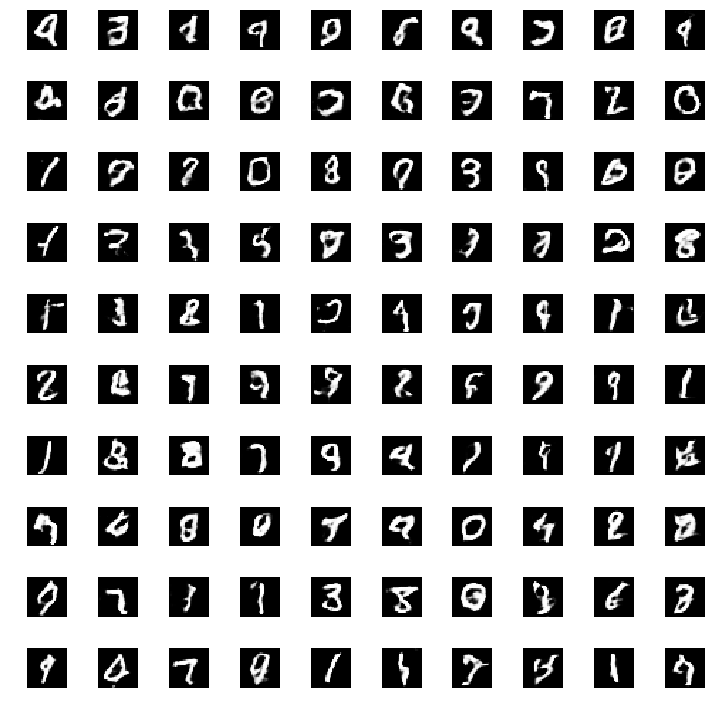

In [46]:
plot_output()

### Generate new numbers from GAN learned over 60 epochs
Load the learned weights and apply them for generating fake images:

In [47]:
generator.load_weights('gen_60_scaled_images.h5')
discriminator.load_weights('dis_60_scaled_images.h5')

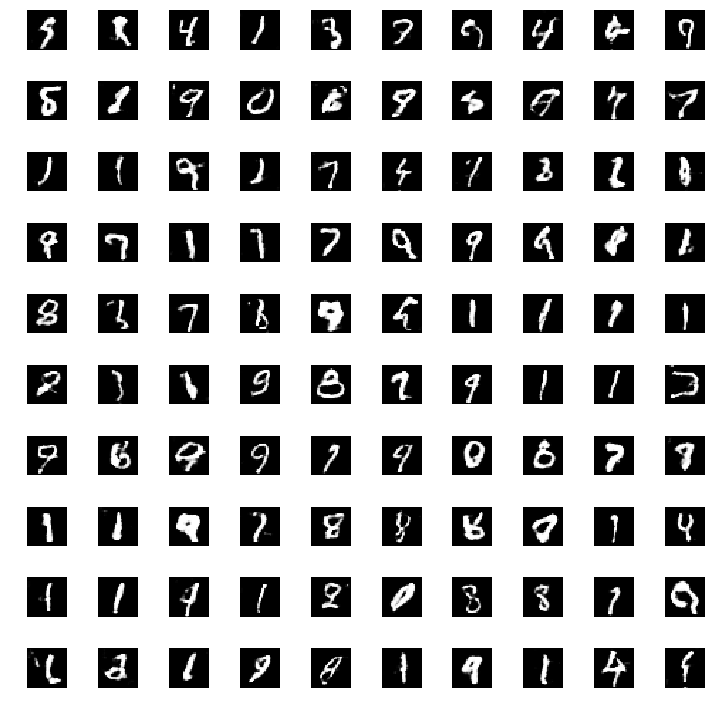

In [48]:
plot_output()